# Importing 
Importing necessary libraries and loading the PreTrained MobileNetV2 model

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
import glob
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from PIL import Image
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights="MobileNet_V2_Weights.DEFAULT")

# Custom loss functions

Following the paper's description of loss function as wrong_NLL()
Proposing our own description of loss function as NLL()

The first 140 elements are the flattened landmarks and the last 70 values correspond to the uncertainities

In [48]:
def wrong_NLL(output, # Tensor of shape [b_sze, 210 (70 landmarks by 3)]
             target, # Tensor of shape [b_sze,140]
             ):

    """
    The output structure is essentially a 2d tensor of of shape [b_sze, 210 (70 landmarks by 3)].
    Each instance (210 length vector) are a sequence of (x,y) locations for 70 landmarks which makes the first 136 elements. The rest 70 elements of the vector 
    are the standard deviation of the probabilistic regression.
    """
    b_sze = output.size()[0]

    crit = nn.MSELoss(reduction='none')
    loss = crit(output[:,:140].view(b_sze,2,-1), target.view(b_sze,2,-1))
    loss = torch.sum(loss,dim=1)
    loss = loss/(2*output[:,140:]**2)
    
    return torch.sum(torch.log(output[:,140:]**2)) + torch.sum(loss)/140


def NLL(output, # Tensor of shape [b_sze, 210 (70 landmarks by 3)]
        target, # Tensor of shape [b_sze,140]
             ):

    """
    The output structure is essentially a 2d tensor of of shape [b_sze, 210 (70 landmarks by 3)].
    Each instance (210 length vector) are a sequence of (x,y) locations for 70 landmarks which makes the first 140 elements. The rest 70 elements of the vector 
    are the standard deviation of the probabilistic regression.
    """
    
    b_sze = output.size()[0]

    crit = nn.MSELoss(reduction='none')
    loss = crit(output[:,:140].view(b_sze,2,-1), target.view(b_sze,2,-1))
    loss = torch.sum(loss,dim=1)
    loss = loss/(2*output[:,140:]**2)
    
    return (torch.sum(0.5*(torch.log(output[:,140:]**2))) + torch.sum(loss))/140

# Custom Dataset Class

The class read root directory location and generates normalised values of images and landmarks

The image is mapped to range [0,1] after being resized to 224x224

The landmarks is mapped to range [-1,1] 

In [49]:
class FaceLandmarksDataset(Dataset):
    def __init__(self,root_dir):
        self.root_dir = root_dir
        self.len = 0
        
    def __len__(self):
        files = os.listdir(self.root_dir)
        self.len = int(len(files)/3)
        return self.len
        
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        item_name = str(idx)
        item_name = item_name.zfill(6)
        
        img_name = self.root_dir+item_name+".png"
        
        ldmks_file_name = self.root_dir+item_name+"_ldmks.txt"
        with open(ldmks_file_name) as f:
            landmarks = np.loadtxt(f)
        landmarks = torch.tensor(landmarks)
        landmarks = torch.reshape(landmarks,(140,))
        landmarks = landmarks/256 - 1
        
        img = Image.open(img_name)
        resizer = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
        img = resizer(img)
        
        sample = {"image":img,"landmarks":landmarks}
        
        return sample

# Dataloading

Created a split of 90% to 10% of training and test with a batch size of 8

In [50]:
dataset = FaceLandmarksDataset("/workspace/EECE7370-Final/Dataset/")
training_data,testing_data = random_split(dataset,[900,100]) 
train_dataloader = DataLoader(training_data,batch_size=8,shuffle=True)
test_dataloader = DataLoader(testing_data,batch_size=8,shuffle=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Facial Landmark Detector Model

Used pretrained weights of MobileNetV2 CNN feature extractor and converting the final layer to output 210 values(70 x and y coordinates and 70 uncertainities

In [51]:
feature_extractor = model.features
class Mobile_LandmarkDetector(nn.Module):
    def __init__(self,feature_extractor_model):
            super().__init__()
            self.feature_extractor_model = feature_extractor_model
            self.regressor_op = nn.Sequential(nn.Dropout(p=0.5),nn.Linear(in_features=1280,out_features=210,bias=True))
    
    def forward(self,x):
        x = self.feature_extractor_model(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x,1)
        x = self.regressor_op(x)
        
        return x

our_model = Mobile_LandmarkDetector(feature_extractor_model=feature_extractor)

# Training and Optimization

Will be only training the last layer and freeze the feature extractor layers

With AdamW optimizer and 100 epochs

In [ ]:
writer = SummaryWriter()

our_model.to(device)
#for param in our_model.feature_extractor_model.parameters():
#    param.requires_grad = False

optimizer = torch.optim.AdamW(our_model.parameters())

mse = nn.MSELoss(reduction="mean") #NME
#crit = nn.GaussianNLLLoss(reduction="sum")
best_model_NLL = our_model
best_loss = np.inf
#Training
for q in range(55):
    our_model.train()
    print(f"epoch {q}")
    for i,(batch) in enumerate(train_dataloader):
        ip,op = batch["image"],batch["landmarks"]
        ip = ip.to(device)
        op = op.float().to(device)
        optimizer.zero_grad()
        pred_op = our_model(ip)
        #landmarks = pred_op[:,:140]
        #landmarks = torch.reshape(landmarks,(-1,70,2))
        #var = pred_op[:,140:]**4
        #op = torch.reshape(op,(-1,70,2))
        #loss = crit(landmarks,op,var)
        loss = NLL(pred_op,op)
        loss.backward()
        optimizer.step()
    
    writer.add_scalar("Training Loss:", loss.item(), q)
        
    our_model.eval()    
    with torch.no_grad():
        tot_loss = 0
        for i_val,(batch_val) in enumerate(test_dataloader):
            ip_test,op_test = batch_val["image"],batch_val["landmarks"]
            ip_test = ip_test.to(device)
            op_test = op_test.float().to(device)
            pred_op = our_model(ip_test)
            l = mse(pred_op[:,:140],op_test)
            tot_loss += l.item()
            
        tot_loss = tot_loss/testing_data.__len__()
        writer.add_scalar("Testing Loss",tot_loss,q)
        
    if tot_loss < best_loss:
        best_loss = tot_loss
        best_model_NLL = our_model

    print(f"Training loss is {loss.item()}, validation loss is {tot_loss}")

writer.flush()

epoch 0
Training loss is 0.7710530757904053, validation loss is 0.011924817264080047
epoch 1
Training loss is 0.247089684009552, validation loss is 0.015834589526057243
epoch 2
Training loss is 0.5069504976272583, validation loss is 0.04137253165245056
epoch 3
Training loss is 0.3695543110370636, validation loss is 0.027239216864109038
epoch 4
Training loss is 0.25150325894355774, validation loss is 0.028058715015649795
epoch 5
Training loss is 0.4274672865867615, validation loss is 0.034187701046466824
epoch 6
Training loss is 0.4381146728992462, validation loss is 0.03130993857979775
epoch 7
Training loss is 0.5571524500846863, validation loss is 0.08268602848052979
epoch 8
Training loss is 0.683789074420929, validation loss is 0.05553671538829803
epoch 9
Training loss is 1.12152099609375, validation loss is 0.042181110978126525
epoch 10
Training loss is 0.5578163266181946, validation loss is 0.04221880927681923
epoch 11
Training loss is 0.7026122212409973, validation loss is 0.05540

Exception in thread Thread-12:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/tensorboard/summary/writer/event_file_writer.py", line 233, in run
    self._record_writer.write(data)
  File "/opt/conda/lib/python3.8/site-packages/tensorboard/summary/writer/record_writer.py", line 40, in write
    self._writer.write(header + header_crc + data + footer_crc)
  File "/opt/conda/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 766, in write
    self.fs.append(self.filename, file_content, self.binary_mode)
  File "/opt/conda/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 160, in append
    self._write(filename, file_content, "ab" if binary_mode else "a")
  File "/opt/conda/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 164, in _write
    with io.open(filename, mode, 

Training loss is 1.582697868347168, validation loss is 0.0675187772512436
epoch 53
Training loss is 1.158838152885437, validation loss is 0.09459251821041108
epoch 54
Training loss is 1.9894086122512817, validation loss is 0.09009583473205567


# Saving the model

In [9]:
path = "./Model/final_model.pt"
torch.save(best_model_NLL.state_dict(),path)


In [10]:
def show_landmarks(image,landmarks_):
    '''
    image and landmarks are unnormalized
    landmarks are numpy 2d array
    '''
    plt.imshow(image)
    plt.scatter(landmarks_[:, 0], landmarks_[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated
    


In [19]:
#path = "./Model/final_model.pt"
test_model = best_model_NLL
#test_model.load_state_dict(torch.load(path))
test_model.to(device)

ind = 699
img,actual = dataset[ind]["image"],dataset[ind]["landmarks"]

pred = test_model(img.unsqueeze(0).to(device))
pred = pred.squeeze(0)
pred = pred[:140]
#print(torch.t(torch.reshape(pred,(70,2))))
#print(torch.t(torch.reshape(actual,(70,2))))

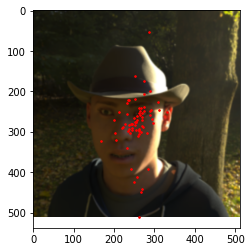

In [20]:
img = img.to("cpu")
resizer = transforms.Resize((512,512))
backToImage = transforms.ToPILImage()
img = resizer(img)
img = backToImage(img)

pred = pred/torch.max(pred)
pred = (pred + 1) * 256
pred = pred.to("cpu")
pred = torch.reshape(pred,(70,2))
pred = pred.detach().numpy()

plt.figure()
show_landmarks(img,pred)
plt.show()